In [1]:
import json
import matplotlib.pyplot as plt
import os
import numpy as np
import mplhep as hep
hep.style.use(hep.styles.CMS)


In [2]:
BASE_DIR = "/home/laurits/ml-tau-en-reg/training-outputs/240826_Long_comparison"
OUTPUT_DIR = "/home/laurits/tmp/plots"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
# BASE_DIR = "/home/laurits/ml-tau-en-reg/training-outputs/240812_3vars"
FRACS = np.array([0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
ALGORITHMS = ['ParticleTransformer', 'OmniParT']
ALL_ALGORITHMS = ['OmniParT', 'ParticleTransformer']
TRAINING_TYPES = ['dm_multiclass', 'jet_regression', 'binary_classification']
COLORS = {
    "OmniParT": 'magenta',
    "ParticleTransformer": "green"
}
MEASURES_OF_INTEREST = {
    "dm_multiclass": ["precision", "recall", "F1"],
    "jet_regression": ["IQR", "median"],
    "binary_classification": ["precision", "recall", "accuracy", "F1"]
}

In [3]:
def get_best_val_loss(path):
    with open(path) as inFile:
        data = json.load(inFile)
    val_losses = np.array(data['loss_validation'])
    return np.min(val_losses), val_losses, data

In [4]:
plotting_data = {}
val_losses = {}
measures_of_interest = {}
for training_type in TRAINING_TYPES:
    plotting_data[training_type] = {}
    val_losses[training_type] = {}
    measures_of_interest[training_type] = {}
    for algorithm in ALGORITHMS:
        plotting_data[training_type][algorithm] = {}
        val_losses[training_type][algorithm] = {}
        measures_of_interest[training_type][algorithm] = {}
        for frac in FRACS:
            frac_str = f"trainfrac_{frac}"
            plotting_data[training_type][algorithm][frac] = []
            val_losses[training_type][algorithm][frac] = 0
            measures_of_interest[training_type][algorithm][frac] = {}
            for tt_MOI in MEASURES_OF_INTEREST[training_type]:
                measures_of_interest[training_type][algorithm][frac][tt_MOI] = 0
            n_versions = 0
            for version in ["v1", "v2", "v3"]:
                path = os.path.join(BASE_DIR, version, frac_str, training_type, algorithm, "history.json")
                if os.path.exists(path):
                    # add MEASURES_OF_INTEREST
                    min_val_loss, val_losses_, data = get_best_val_loss(path)
                    for tt_MOI in MEASURES_OF_INTEREST[training_type]:
                        measures_of_interest[training_type][algorithm][frac][tt_MOI] += np.array(data[f"{tt_MOI}_validation"])
                    plotting_data[training_type][algorithm][frac].append(min_val_loss)
                    val_losses[training_type][algorithm][frac] += val_losses_
                    n_versions += 1
            if n_versions > 0:
                val_losses[training_type][algorithm][frac] /= n_versions
                for tt_MOI in MEASURES_OF_INTEREST[training_type]:
                    measures_of_interest[training_type][algorithm][frac][tt_MOI] /= n_versions


In [5]:
def plot_task_performances(plotting_data, training_type):
    fig, ax = plt.subplots(figsize=(8, 6))
    for algorithm in ALL_ALGORITHMS:
        val_loss_mean, val_loss_stds, fs = get_algorithm_performances(plotting_data[training_type], algorithm)
        plt.plot(fs, val_loss_mean, label=algorithm, color=COLORS[algorithm])
        plt.fill_between(fs, val_loss_mean - val_loss_stds, val_loss_mean + val_loss_stds, color=COLORS[algorithm], alpha=0.3)
    plt.legend()
    plt.xlabel("Training fraction")
    plt.ylabel("Validation loss")
    plt.yscale("log")
    output_path = os.path.join(OUTPUT_DIR, f"{training_type}_val_losses.png")
    plt.savefig(output_path)


def get_algorithm_performances(training_data, algorithm):
    val_loss_mean = []
    val_loss_stds = []
    fs = []
    for frac in FRACS:
        if frac not in training_data[algorithm].keys():
            continue
        else:
            val_loss_mean.append(np.mean(training_data[algorithm][frac]))
            val_loss_stds.append(np.std(training_data[algorithm][frac]))
            fs.append(frac)
    return np.array(val_loss_mean), np.array(val_loss_stds), fs
        

In [6]:
# Losside graafikud

def plot_losses(val_losses, training_type):
    ncols = 2
    nrows = int(np.ceil(len(FRACS) / ncols))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(12, 24))
    i = 0
    
    for idx_row, row in enumerate(ax):
        for idx_col, col in enumerate(row):
            frac = FRACS[i]
            vlosses_ParT = val_losses[training_type]["ParticleTransformer"][frac]
            vlosses_OmniParT = val_losses[training_type]["OmniParT"][frac]
            if type(vlosses_ParT) != int:
                epochs_ParT = np.arange(len(vlosses_ParT))
                col.plot(epochs_ParT, vlosses_ParT, color=COLORS["ParticleTransformer"], label="ParT")
            if type(vlosses_OmniParT) != int:
                epochs_OmniParT = np.arange(len(vlosses_OmniParT))
                col.plot(epochs_OmniParT, vlosses_OmniParT, color=COLORS["OmniParT"], label="OmniParT")
            col.set_title(f"Train frac: {frac}", size=20)
            col.legend(loc="upper right")
            col.set_yscale('log')
            i+= 1
    output_path = os.path.join(OUTPUT_DIR, f"{training_type}_performance_trainFrac.png")
    plt.savefig(output_path)


In [7]:
def plot_measures_of_interest(measures_of_interest, training_type):
    for tt_MOI in MEASURES_OF_INTEREST[training_type]:
        plot_measure_of_interest_evolution(measures_of_interest, training_type, tt_MOI)
        
        # plot_measure_of_interest_frac(measures_of_interest, training_type, tt_MOI)
    # measure_of_interest[training_type][algorithm][frac][tt_MOI]



# def plot_measure_of_interest_frac(measures_of_interest, training_type, tt_MOI):
#     fig, ax = plt.subplots(figsize=(8, 6))
    
#     for algorithm in ALL_ALGORITHMS:
#         for frac in FRACS:
            

#         plt.plot(fractions, min_, label=algorithm, color=COLORS[algorithm])
#         plt.fill_between(fs, val_loss_mean - val_loss_stds, val_loss_mean + val_loss_stds, color=COLORS[algorithm], alpha=0.3)
#     plt.legend()
#     plt.xlabel("Training fraction")
#     plt.ylabel("Validation loss")
#     output_path = os.path.join(OUTPUT_DIR, f"{training_type}_val_losses.png")
#     plt.savefig(output_path)


def plot_measure_of_interest_evolution(measures_of_interest, training_type, tt_MOI):
    ncols = 2
    nrows = int(np.ceil(len(FRACS) / ncols))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=False, figsize=(12, 24))
    i = 0
    
    for idx_row, row in enumerate(ax):
        for idx_col, col in enumerate(row):
            frac = FRACS[i]
            moi_ParT = measures_of_interest[training_type]["ParticleTransformer"][frac][tt_MOI]
            moi_OmniParT = measures_of_interest[training_type]["OmniParT"][frac][tt_MOI]
            if type(moi_ParT) != int:
                epochs_ParT = np.arange(len(moi_ParT))
                col.plot(epochs_ParT, moi_ParT, color=COLORS["ParticleTransformer"], label="ParT")
            if type(moi_OmniParT) != int:
                epochs_OmniParT = np.arange(len(moi_OmniParT))
                col.plot(epochs_OmniParT, moi_OmniParT, color=COLORS["OmniParT"], label="OmniParT")
            col.set_title(f"Train frac: {frac}", size=20)
            col.legend(loc="upper right")
            col.set_yscale('log')
            i+= 1
    fig.suptitle(f"{training_type}: {tt_MOI}")
    output_path = os.path.join(OUTPUT_DIR, f"{training_type}_{tt_MOI}_performance_trainFrac.png")
    plt.savefig(output_path)
    

# Jet regression

/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


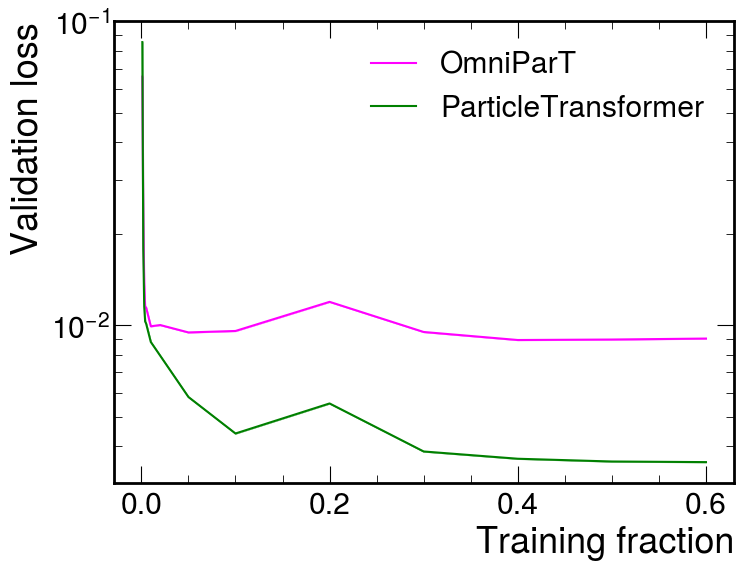

In [8]:
plot_task_performances(plotting_data, "jet_regression")

/tmp/ipykernel_2662791/1252054700.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  col.legend(loc="upper right")


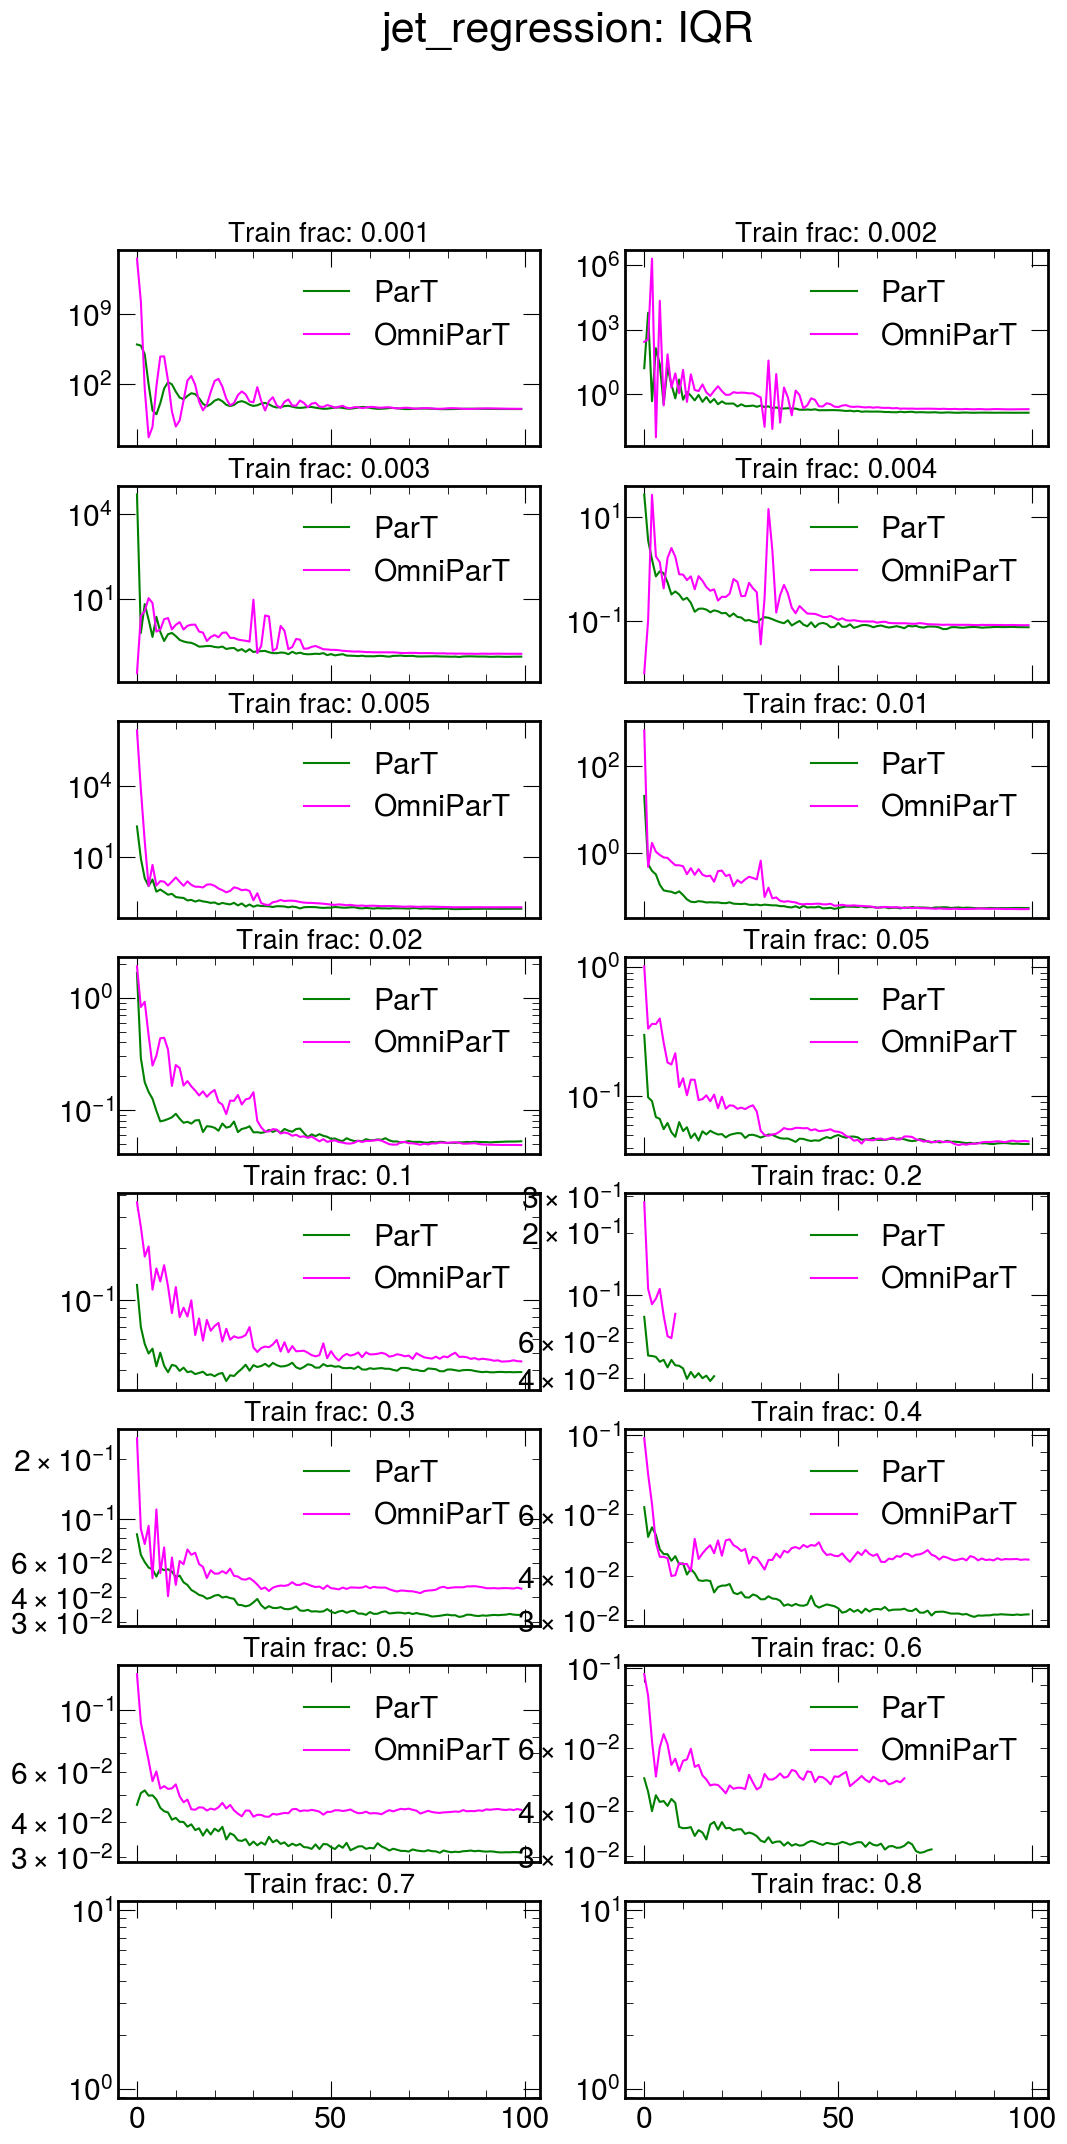

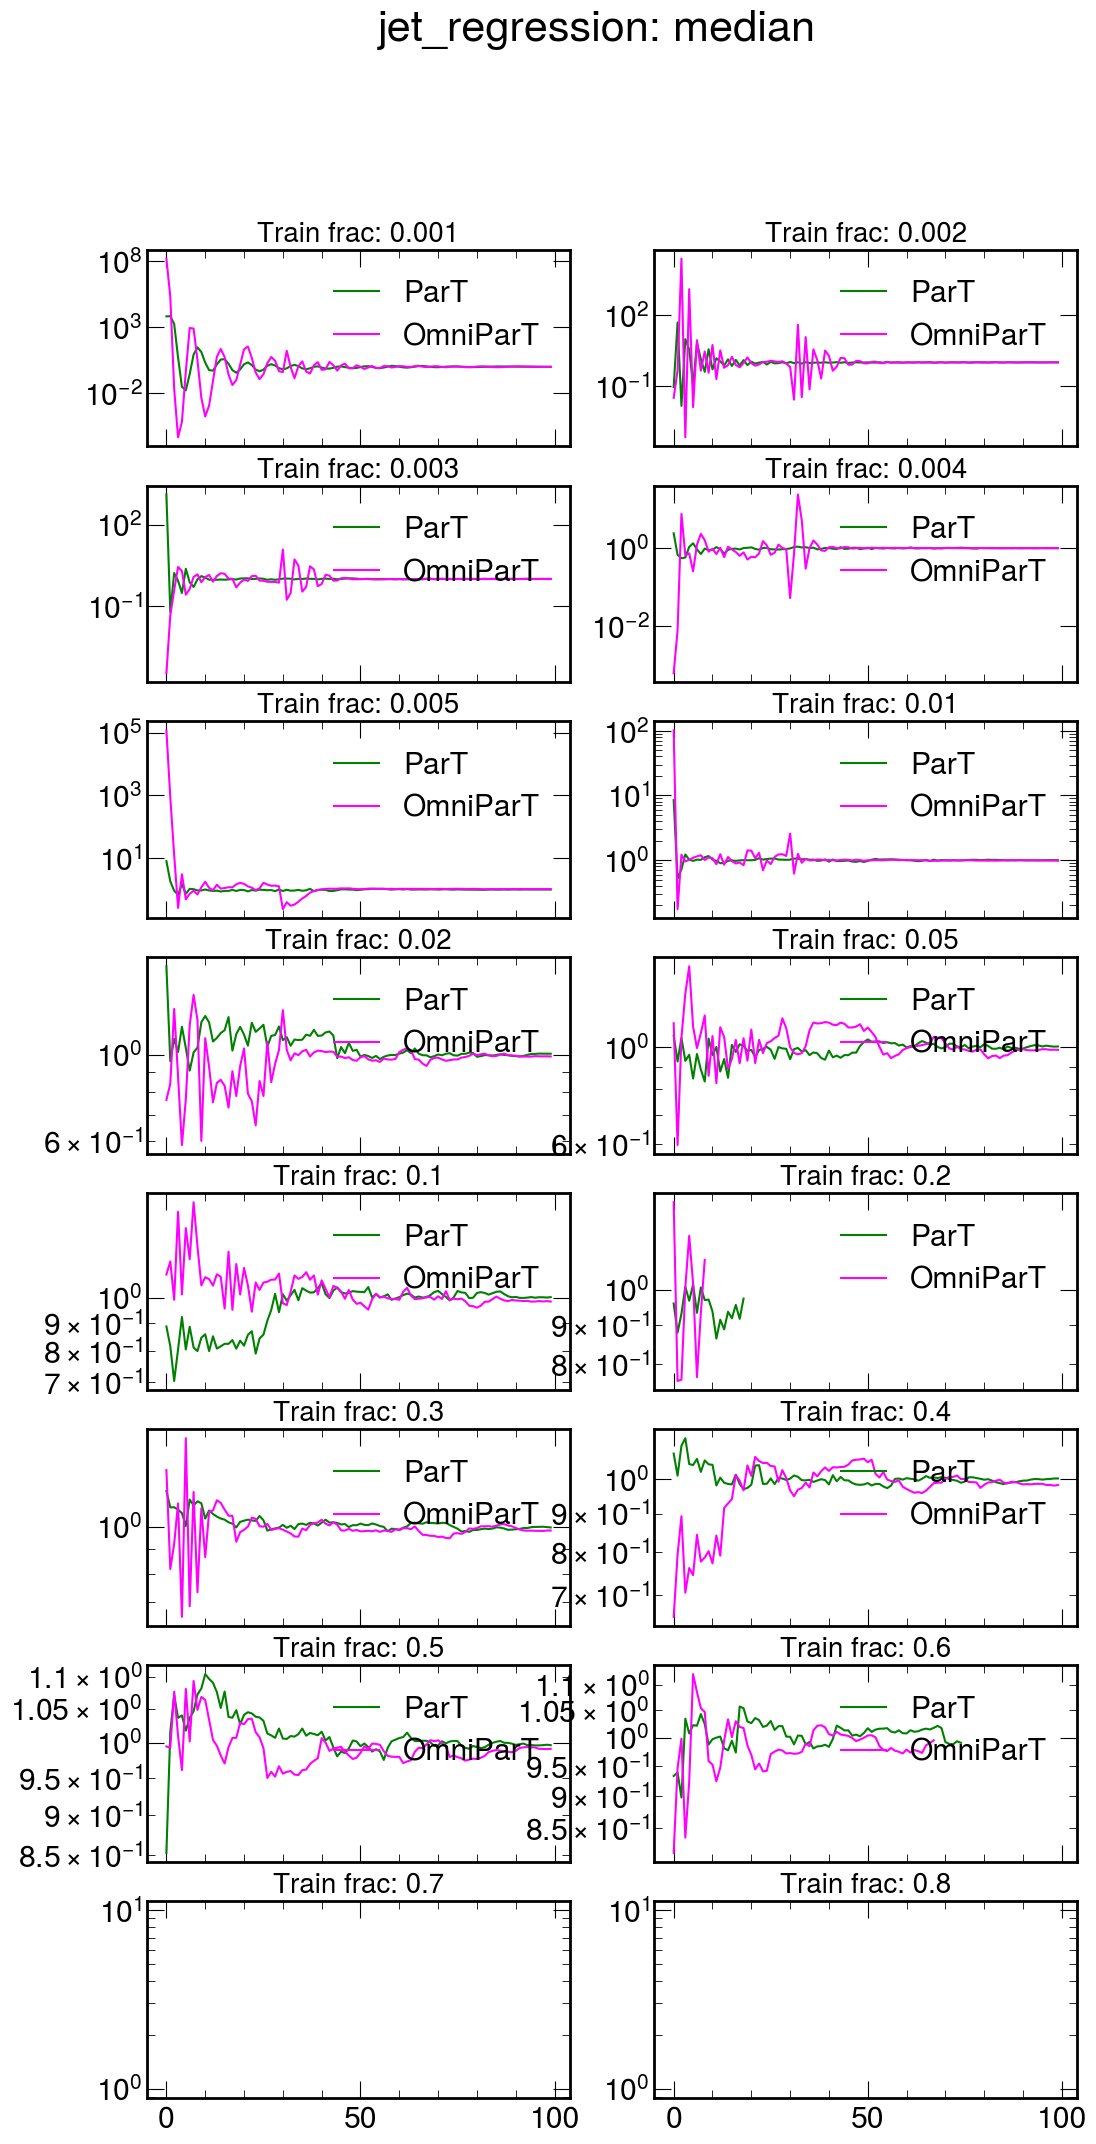

In [9]:
plot_measures_of_interest(measures_of_interest, "jet_regression")

/tmp/ipykernel_2662791/1160993363.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  col.legend(loc="upper right")


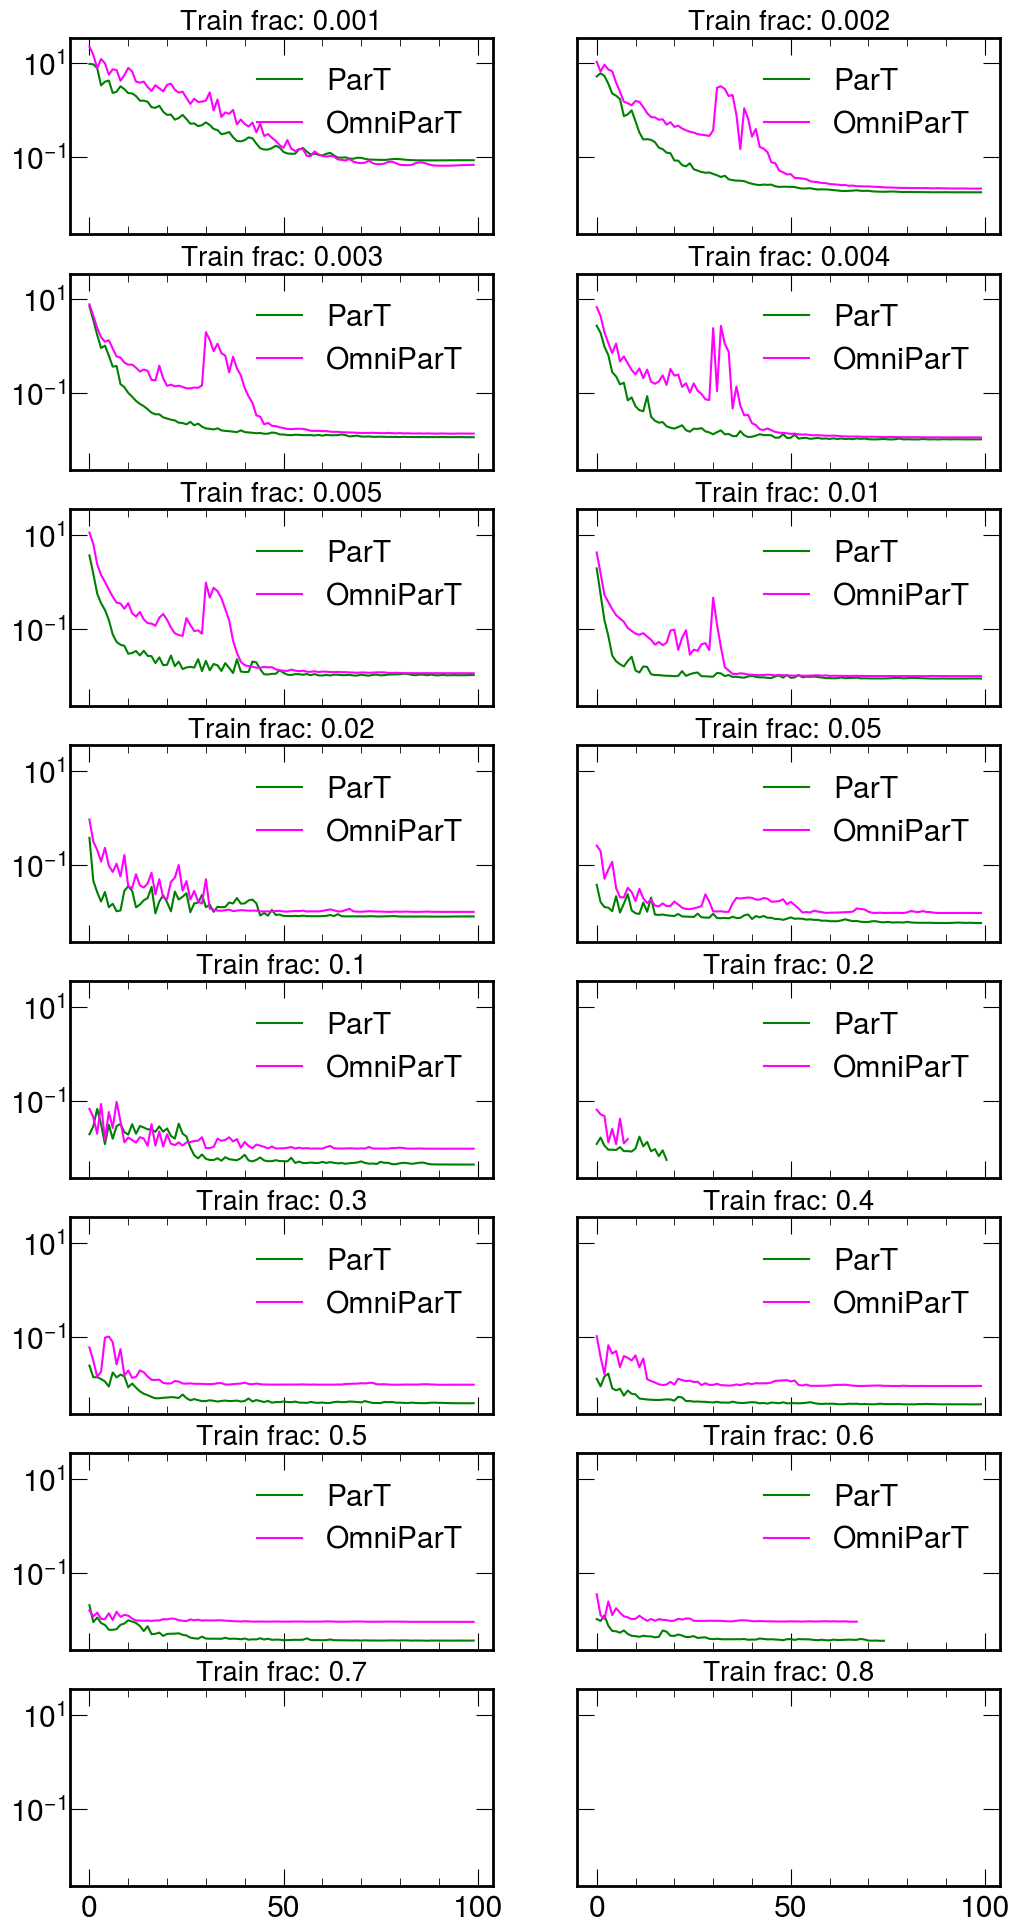

In [10]:
plot_losses(val_losses, "jet_regression")

# Decay mode reconstruction

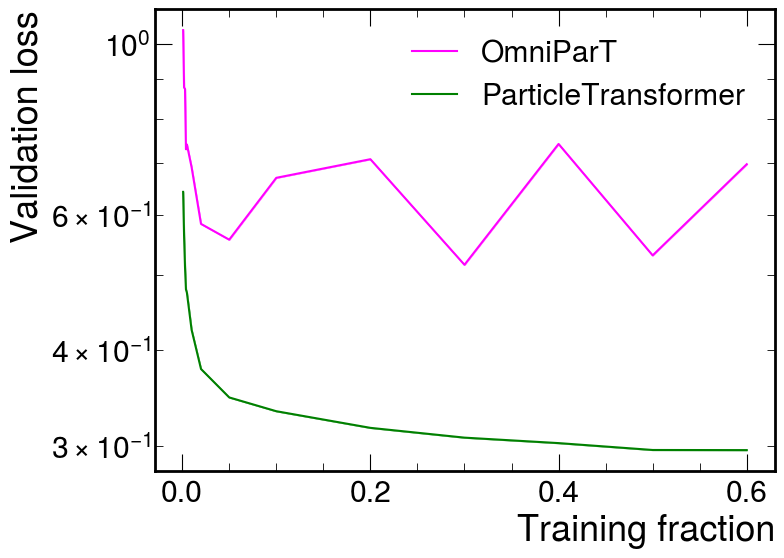

In [11]:
plot_task_performances(plotting_data, "dm_multiclass")


/tmp/ipykernel_2662791/1252054700.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  col.legend(loc="upper right")


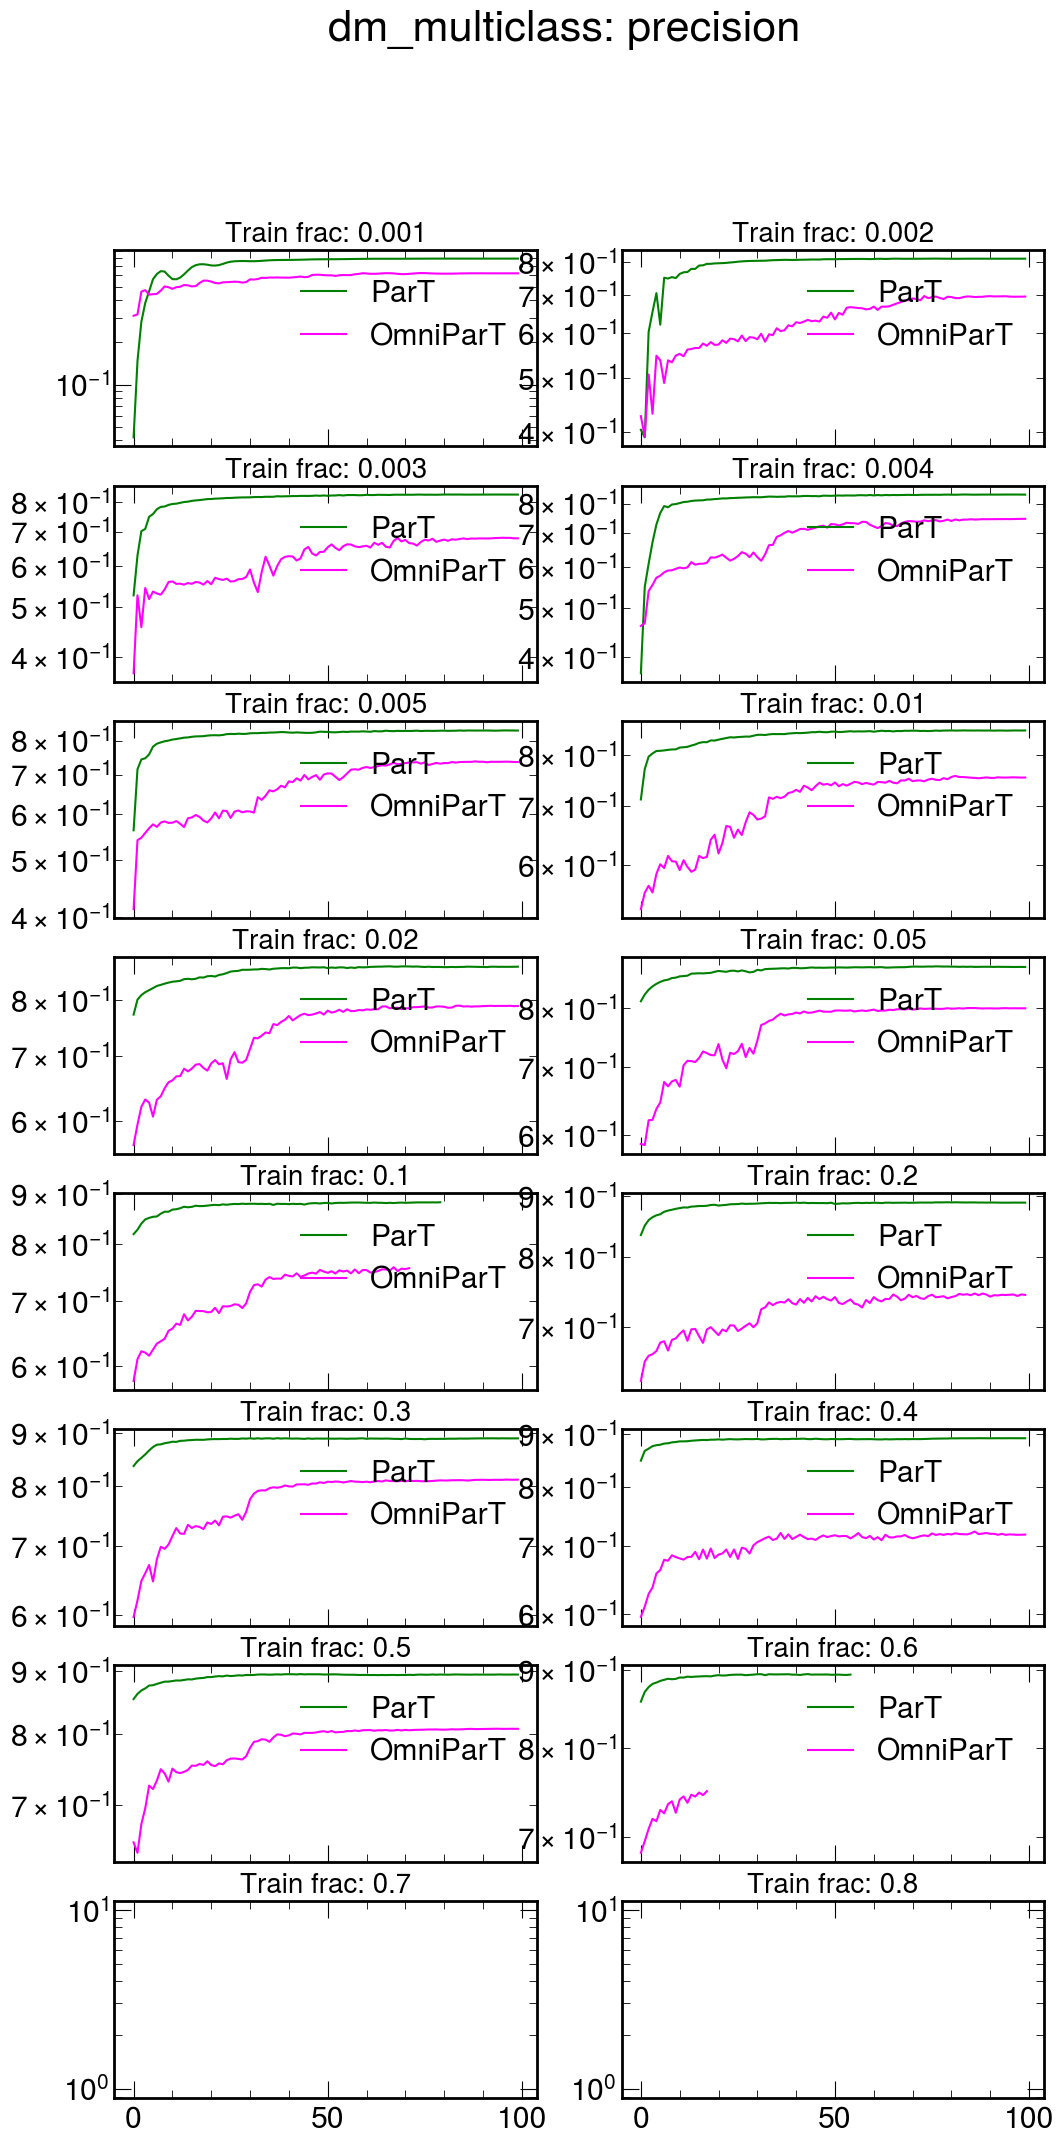

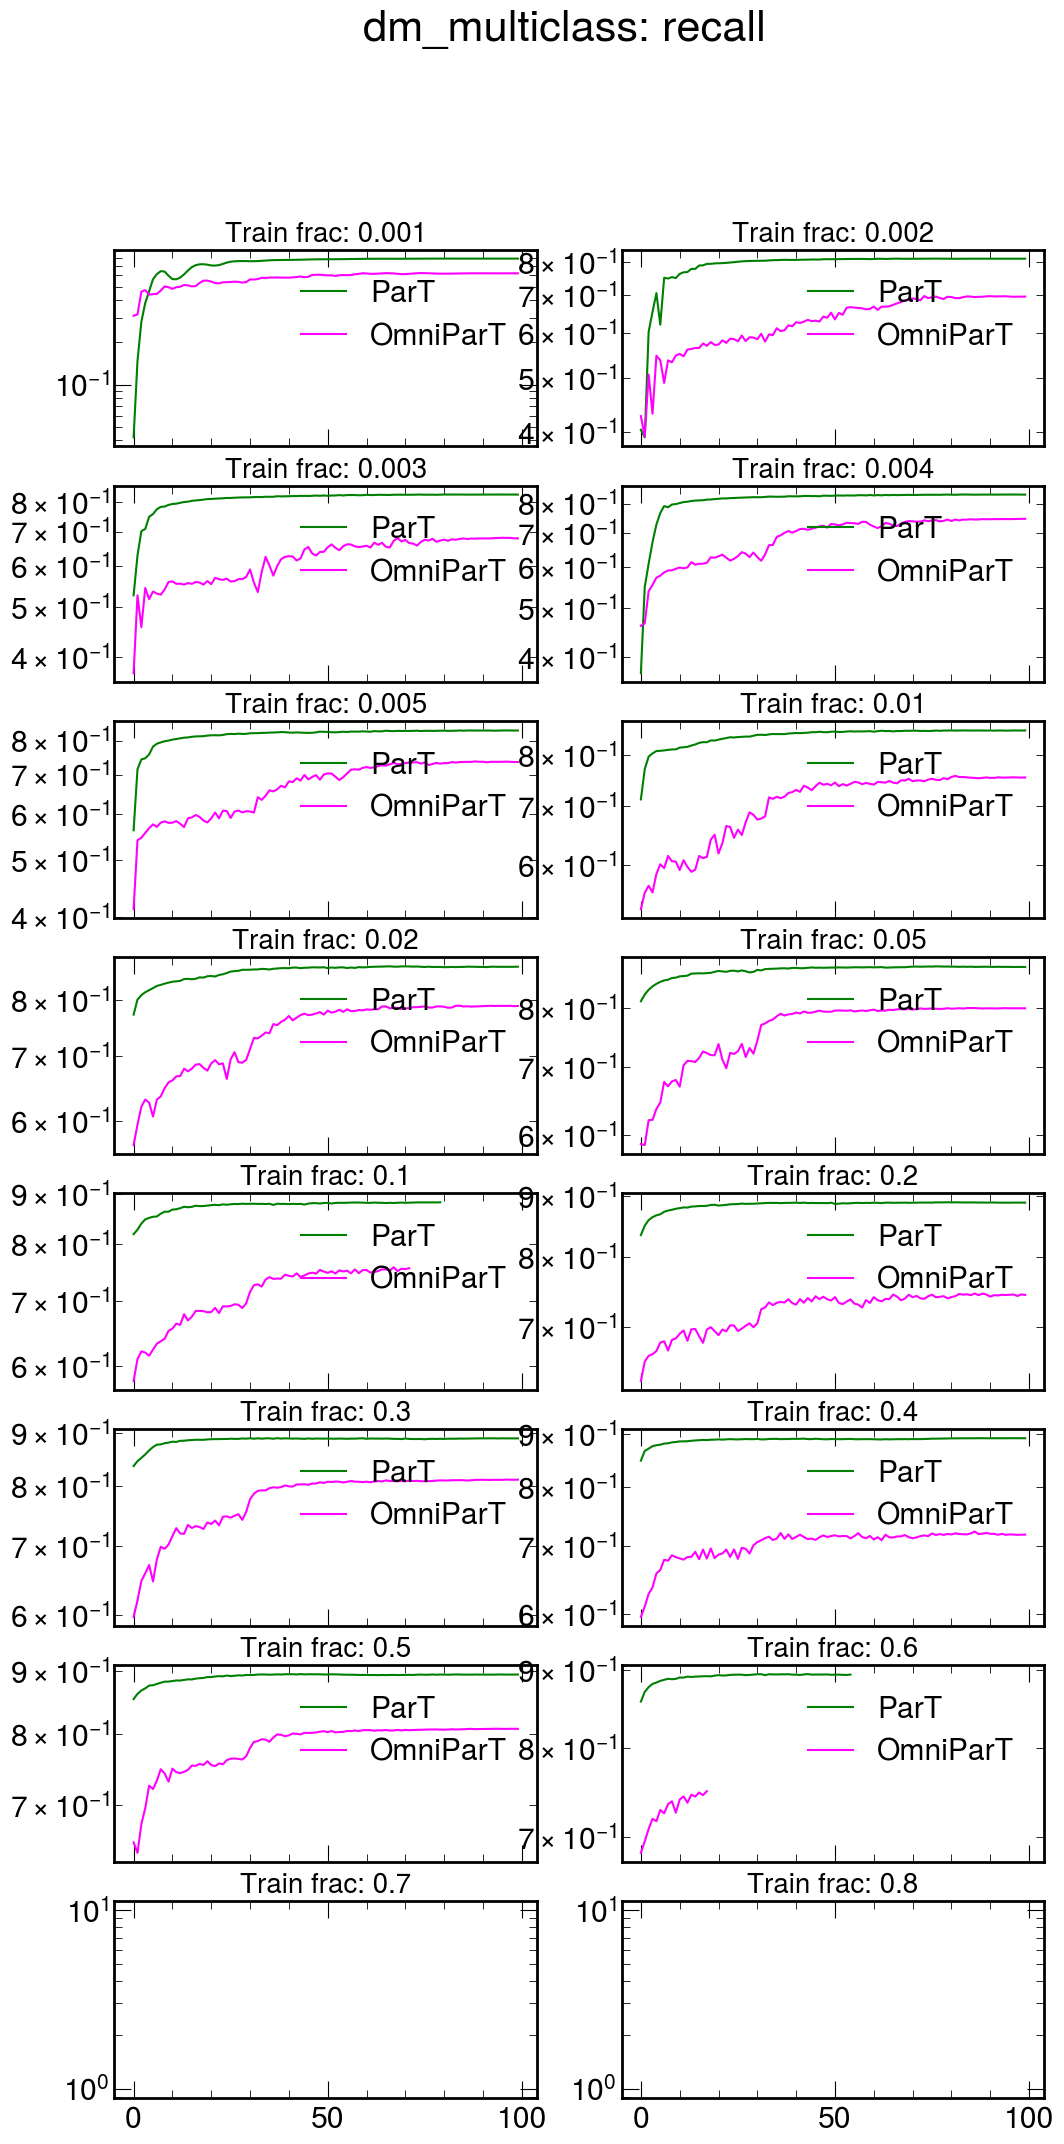

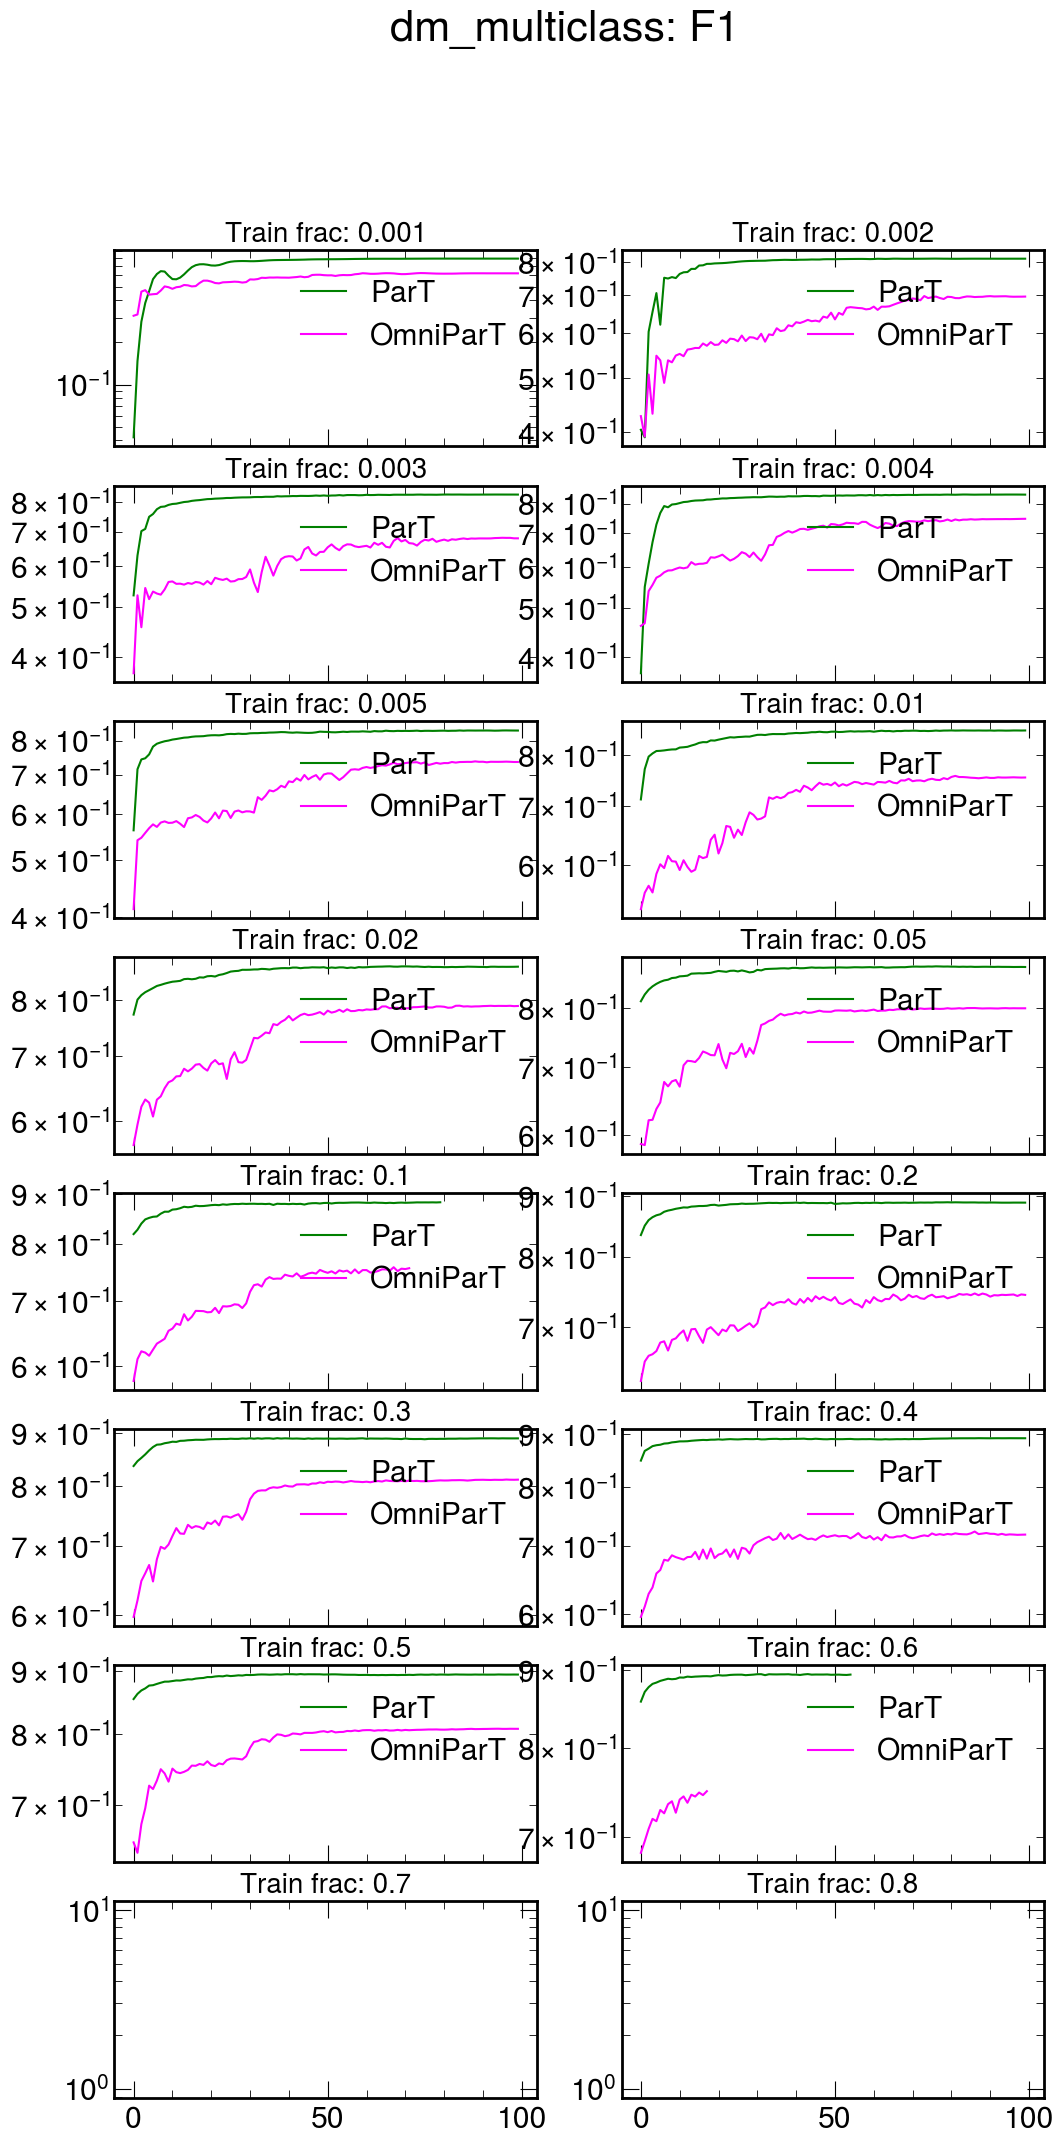

In [12]:
plot_measures_of_interest(measures_of_interest, "dm_multiclass")

/tmp/ipykernel_2662791/1160993363.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  col.legend(loc="upper right")


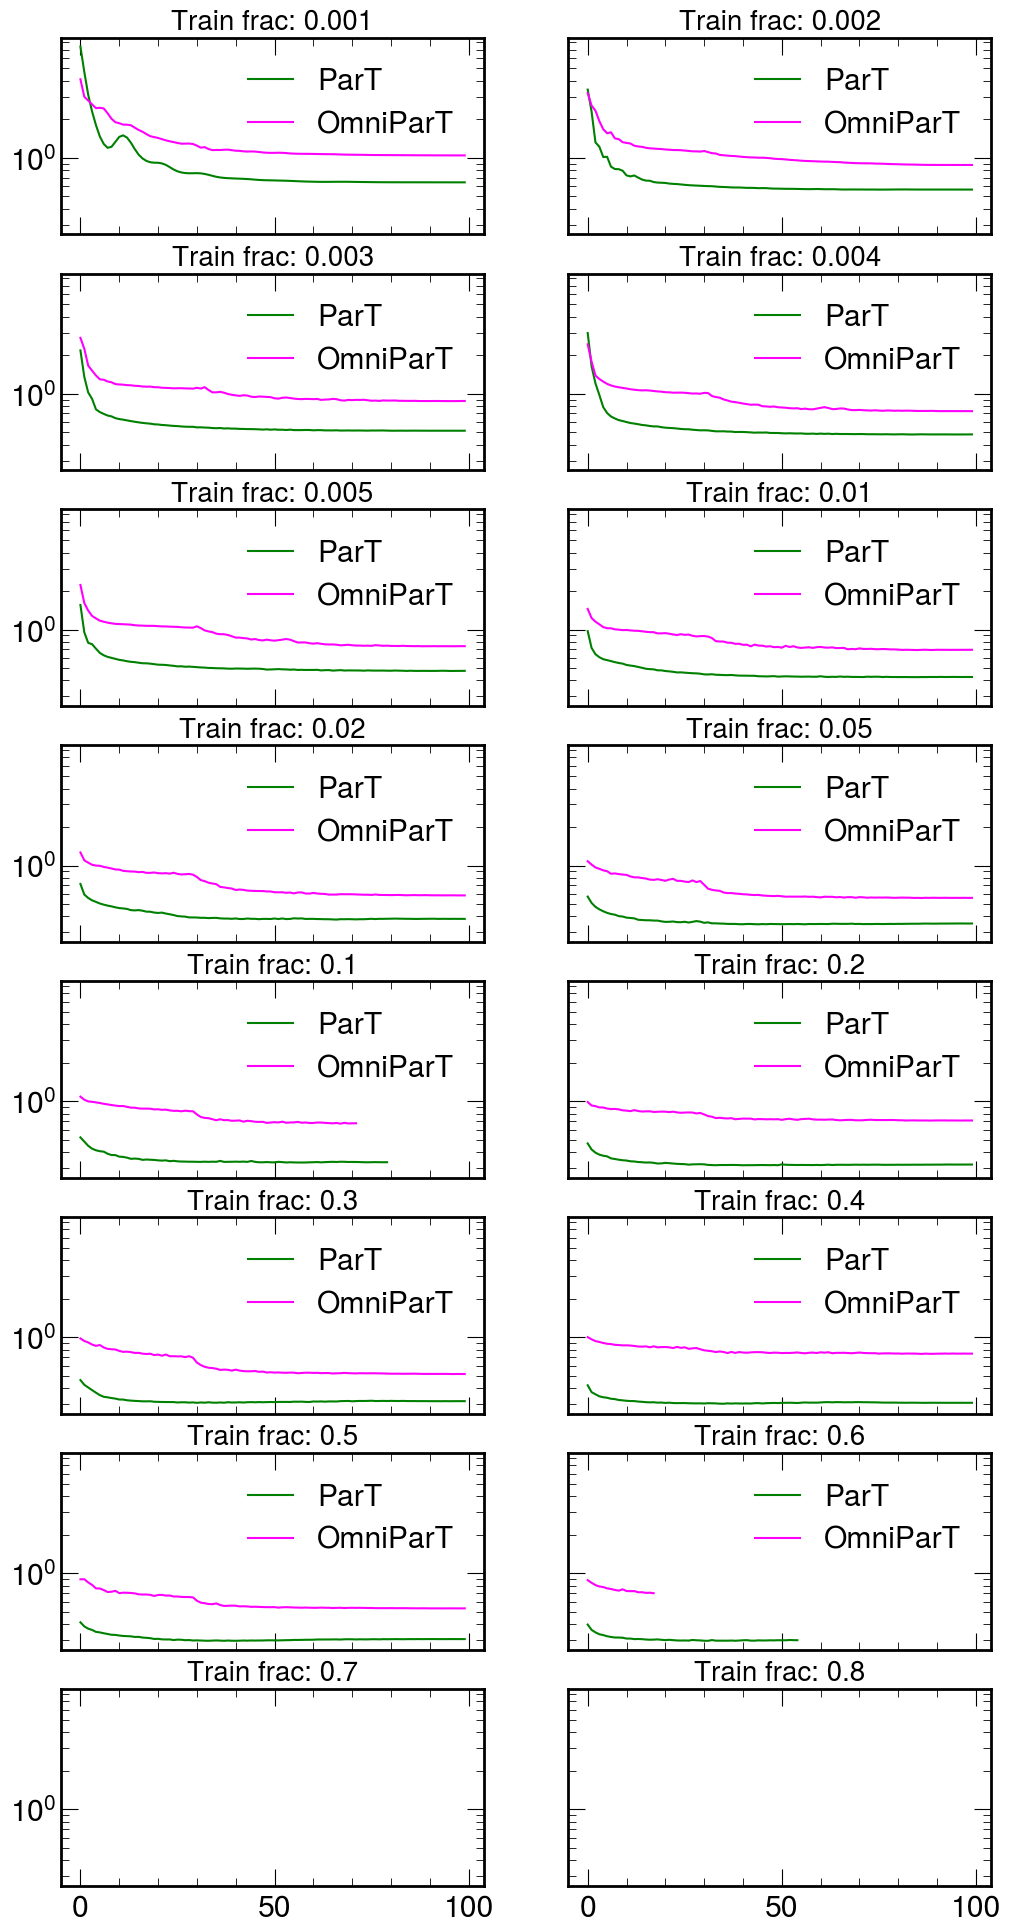

In [13]:
plot_losses(val_losses, "dm_multiclass")

# Binary classification (Tau tagging)


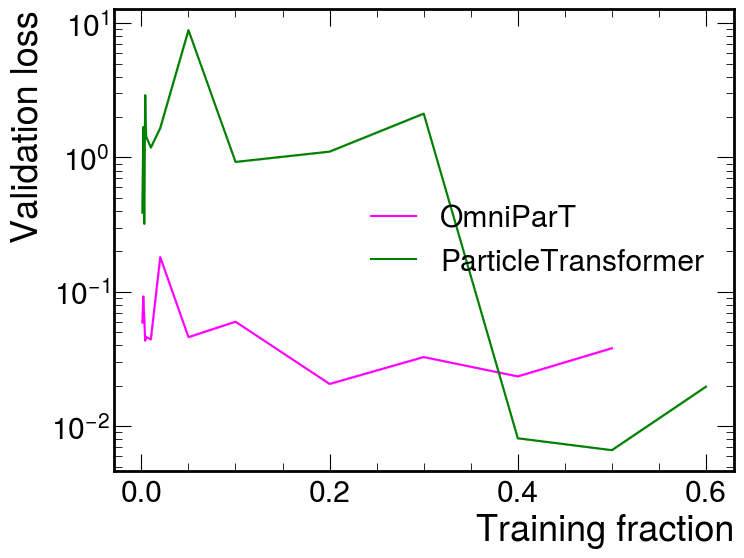

In [14]:
plot_task_performances(plotting_data, "binary_classification")

/tmp/ipykernel_2662791/1252054700.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  col.legend(loc="upper right")


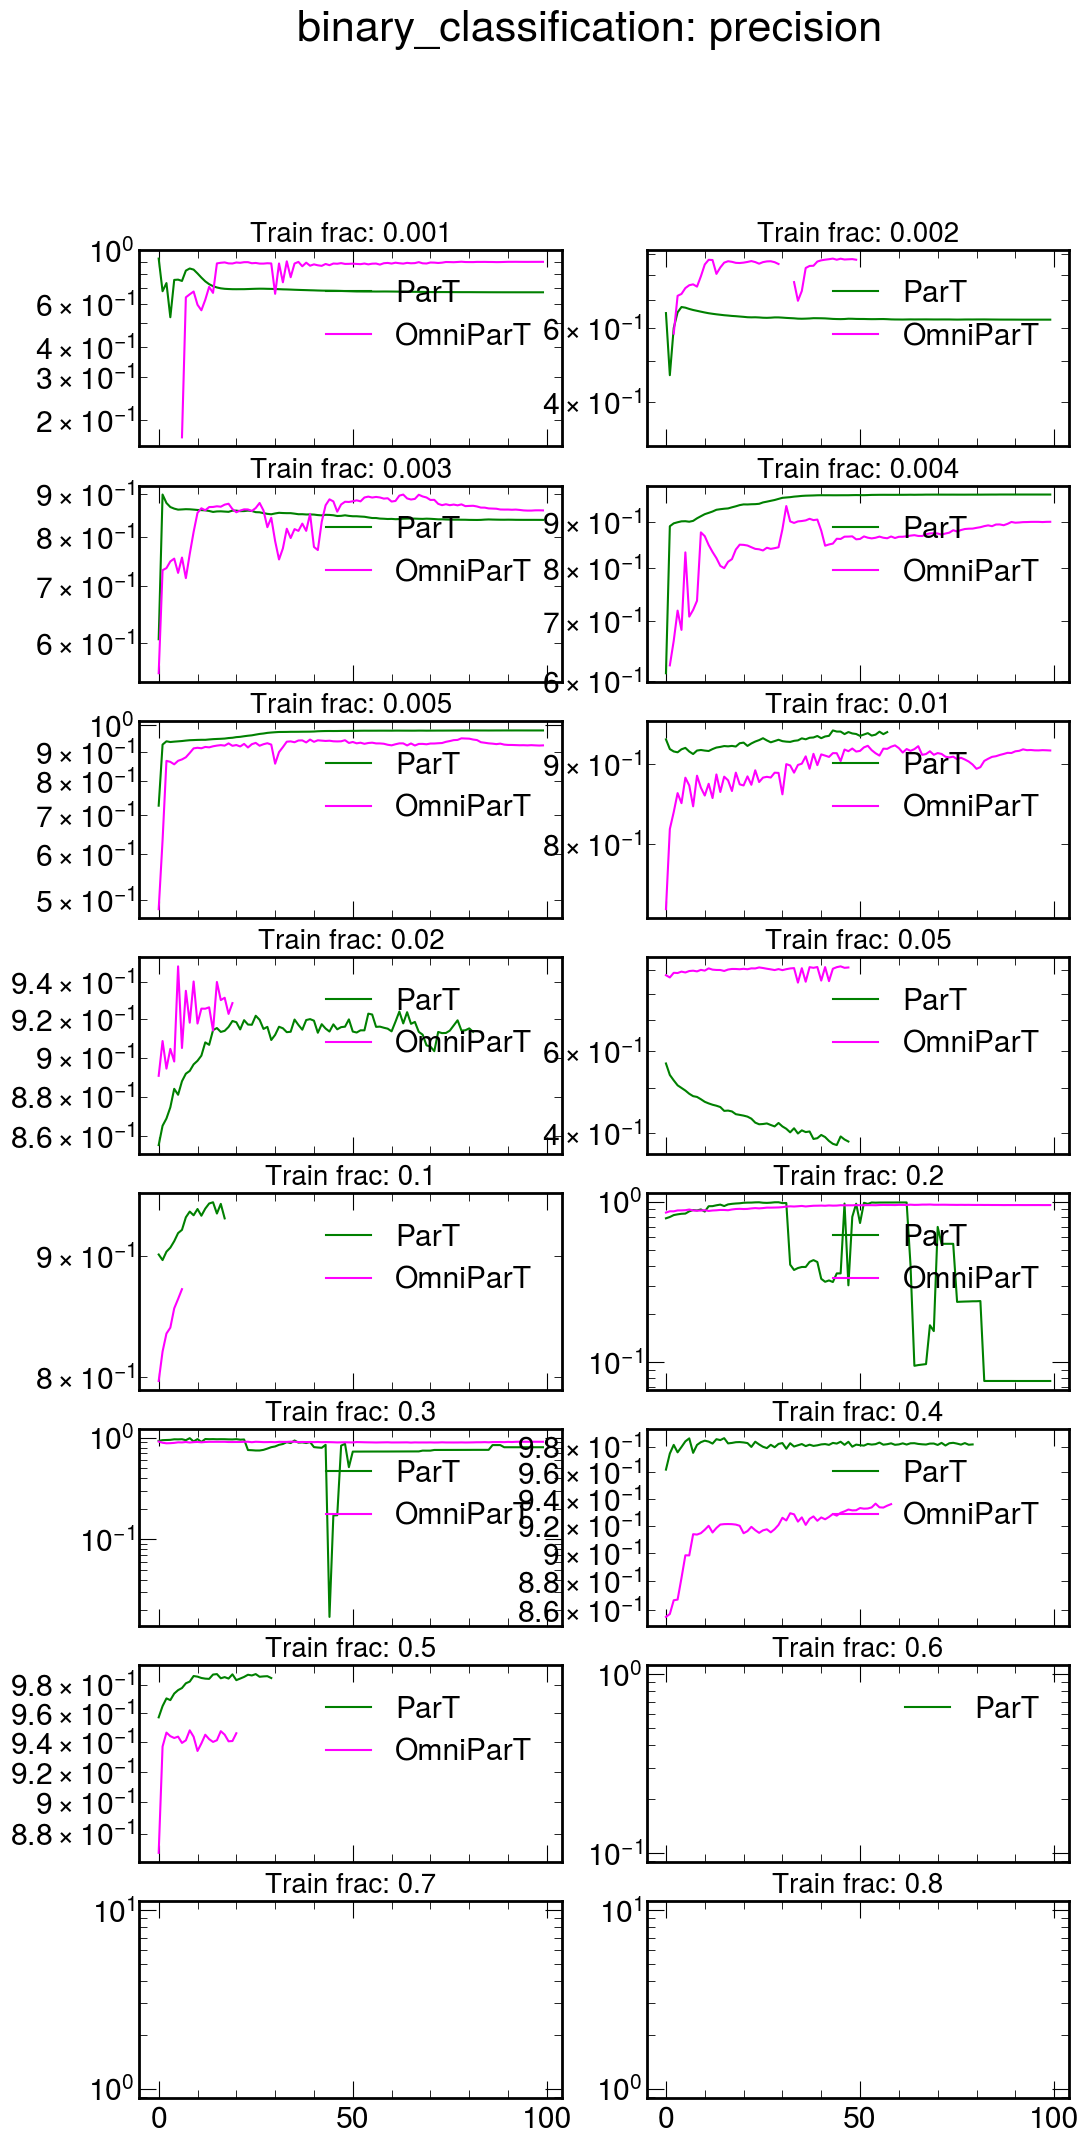

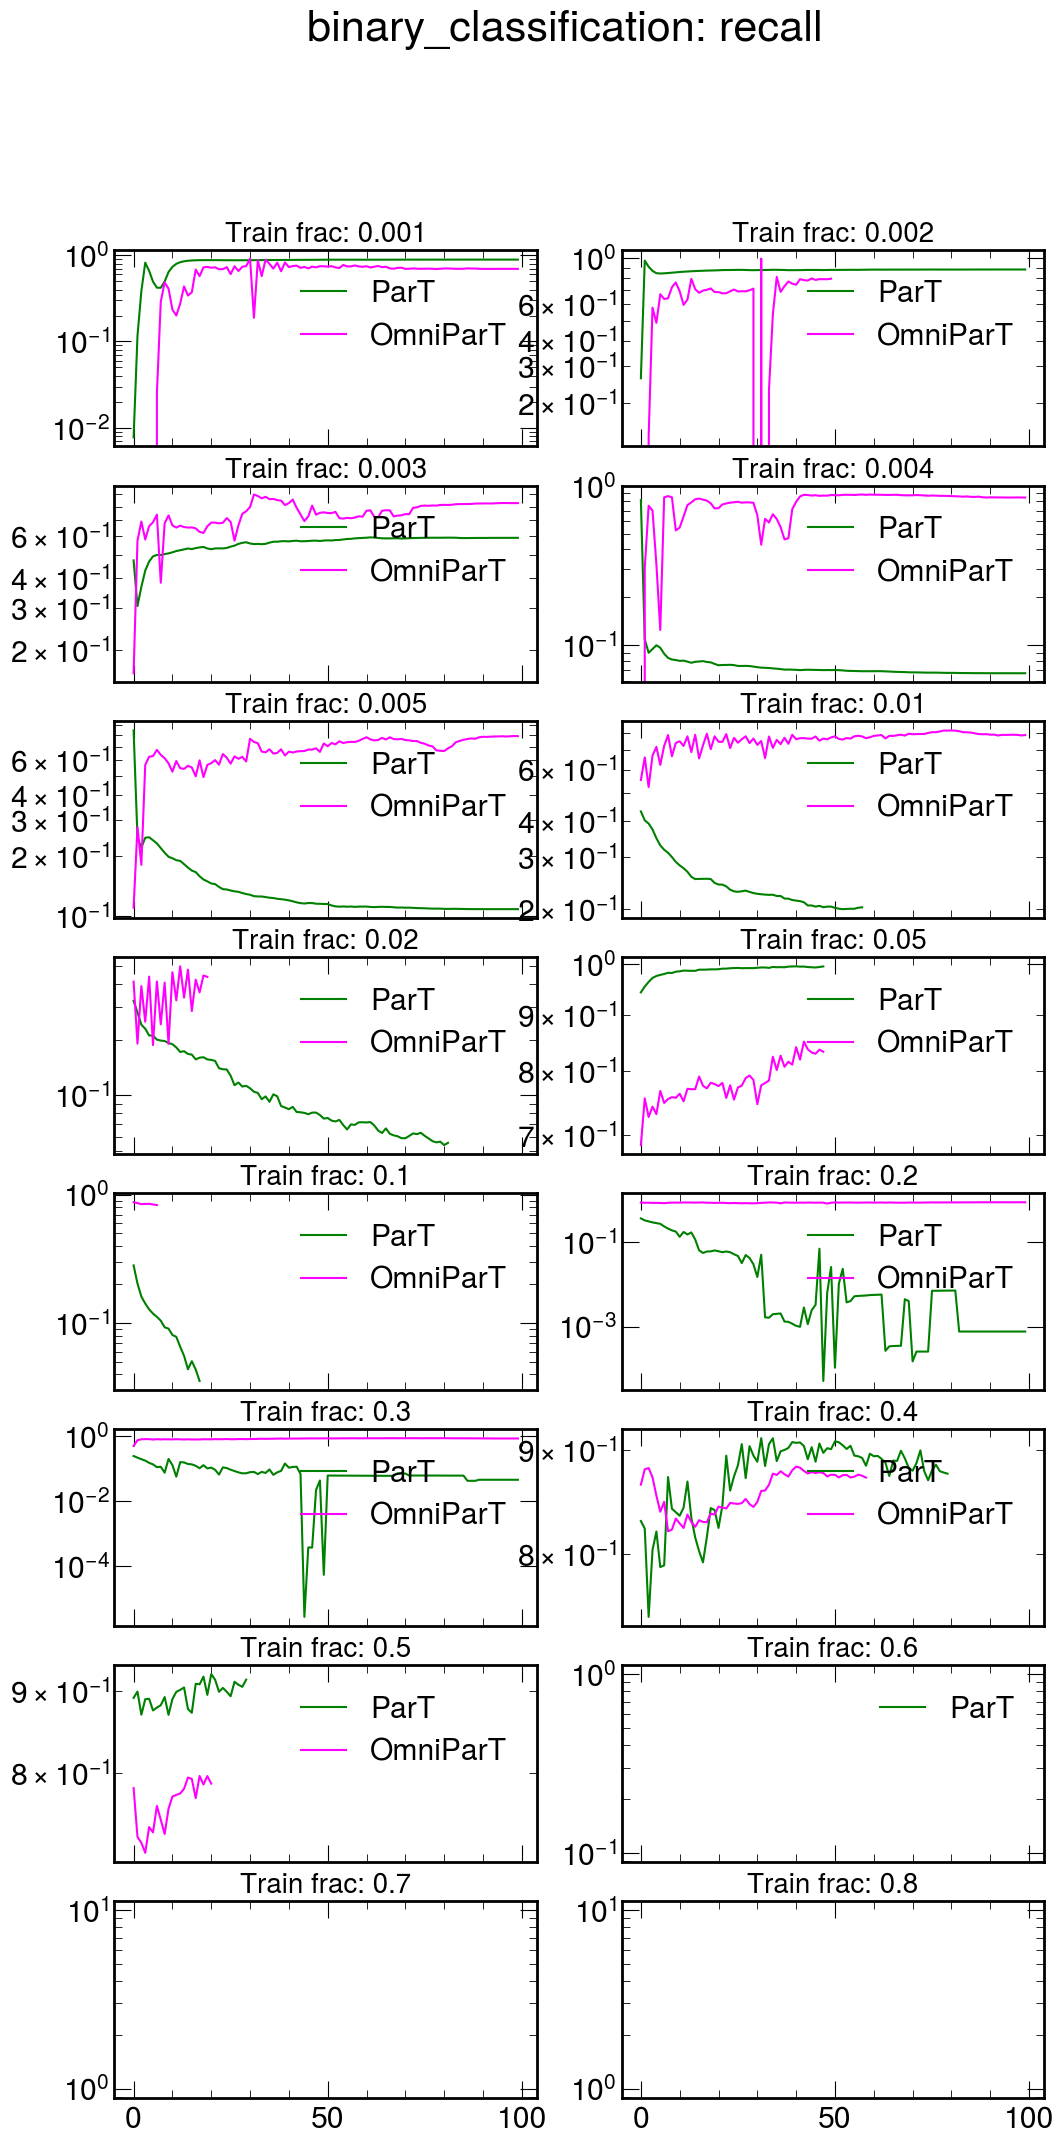

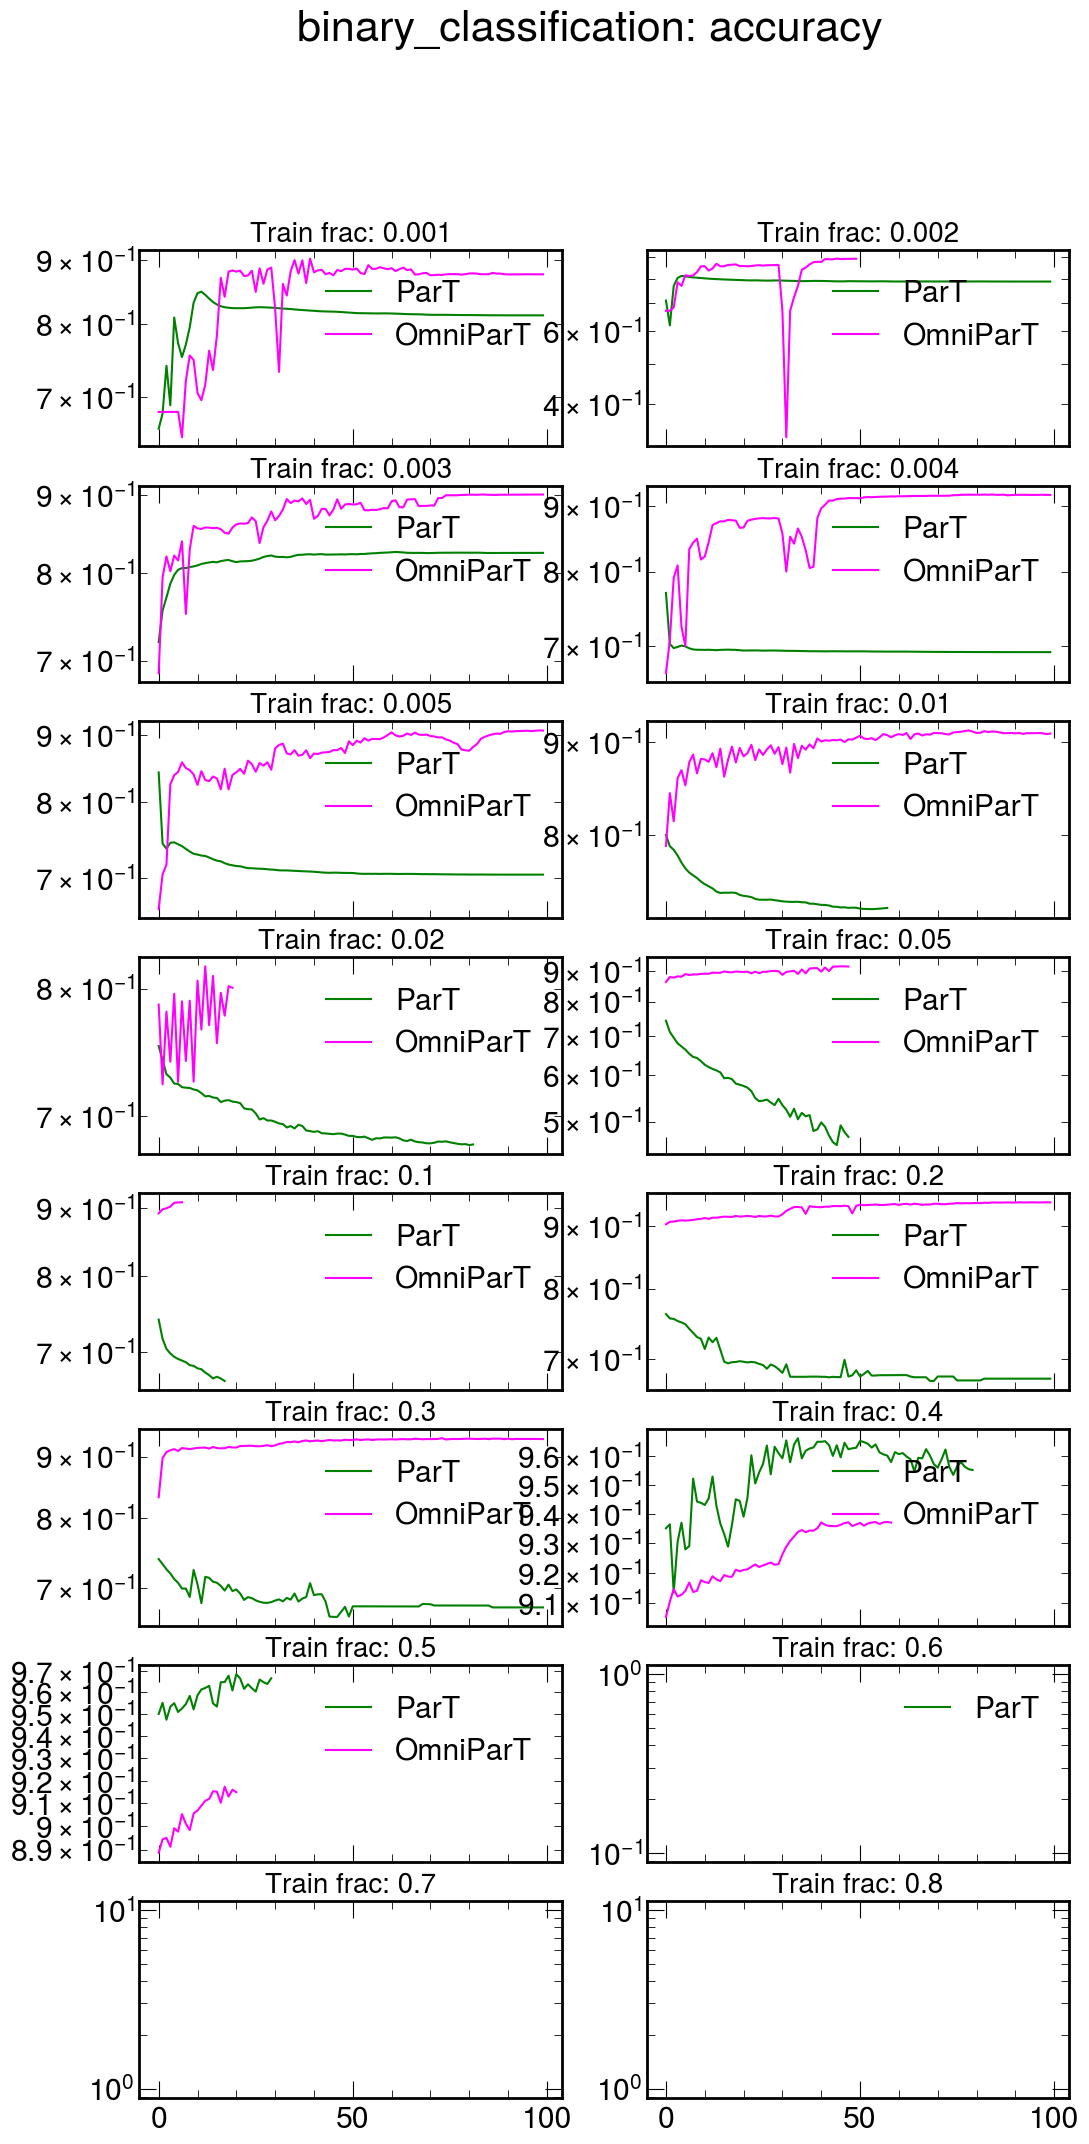

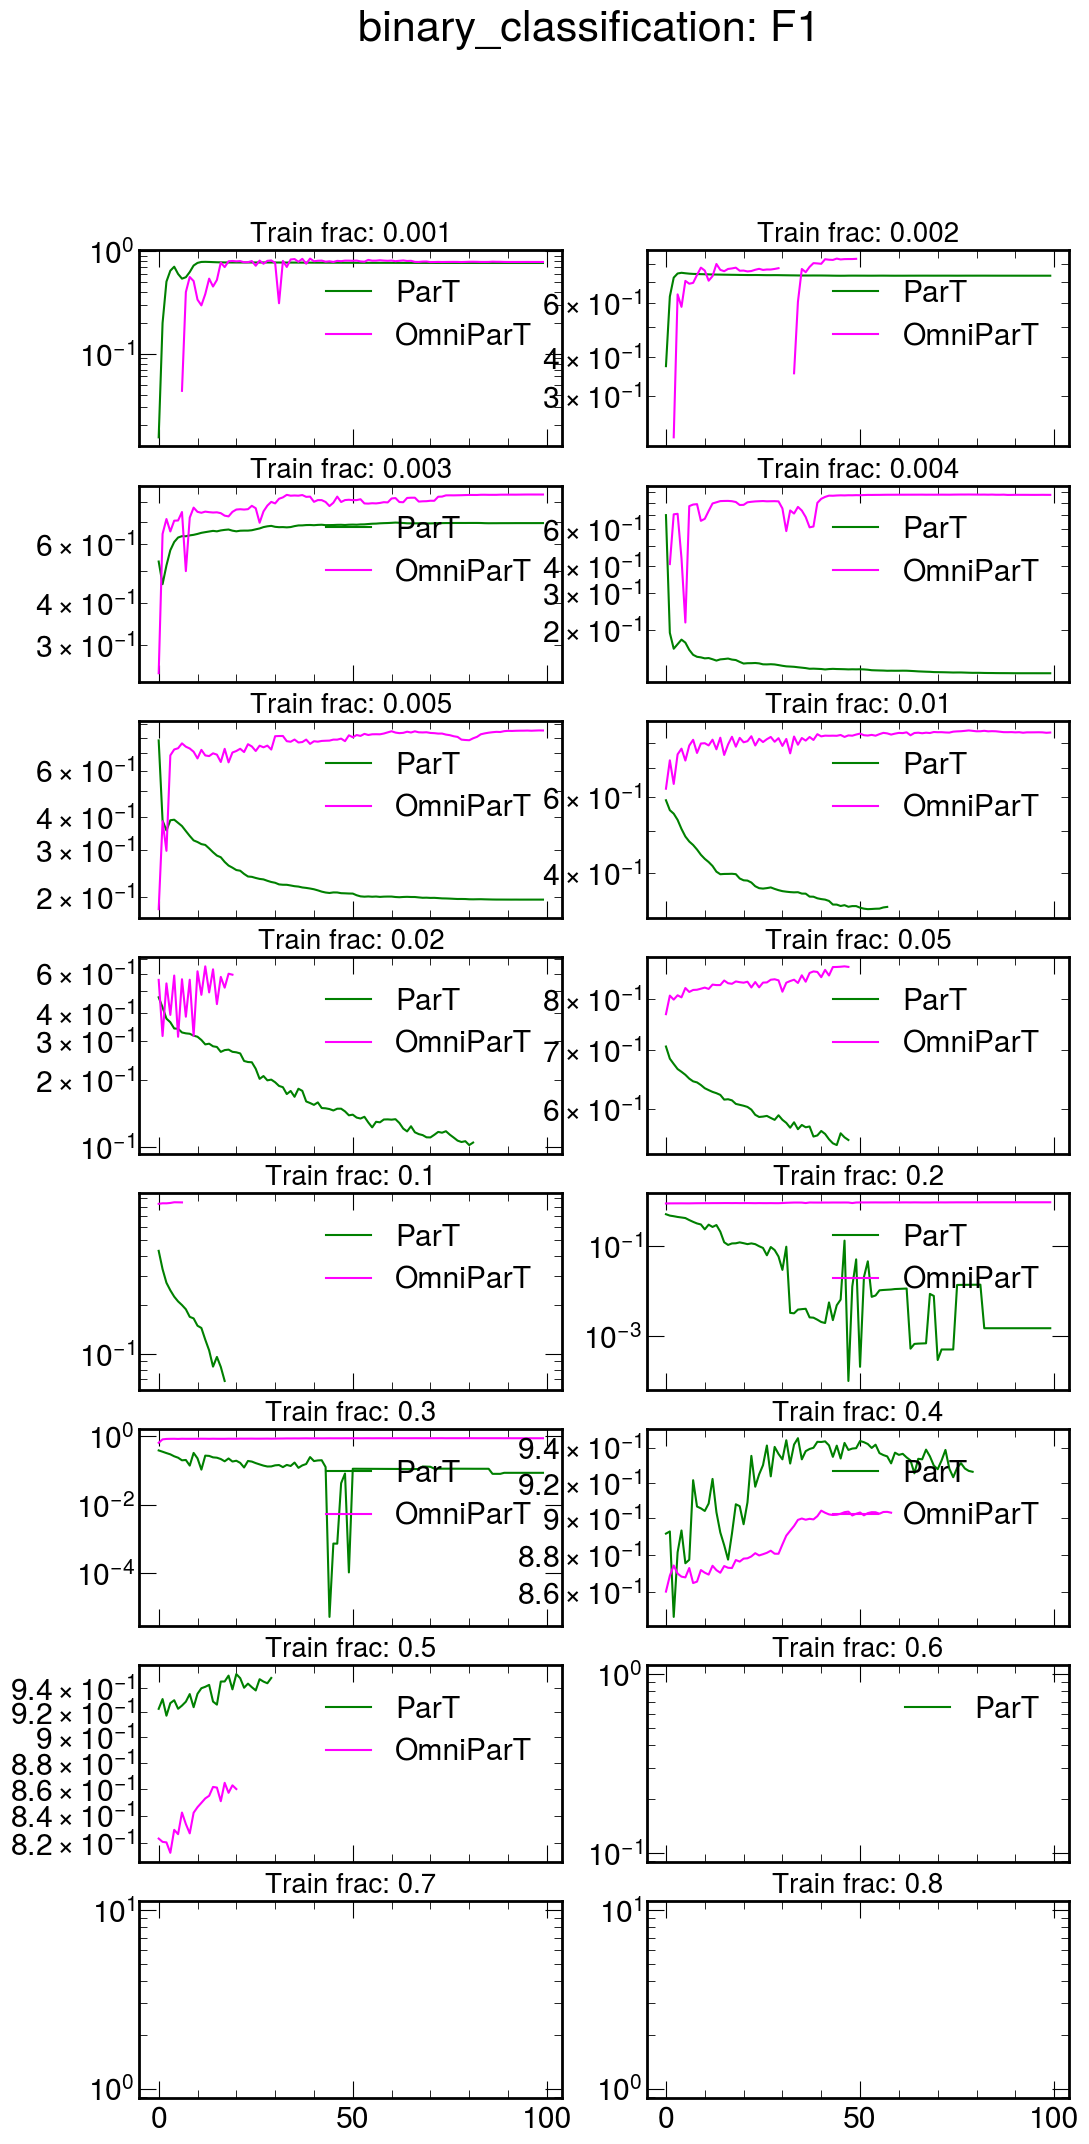

In [15]:
plot_measures_of_interest(measures_of_interest, "binary_classification")

/tmp/ipykernel_2662791/1160993363.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  col.legend(loc="upper right")


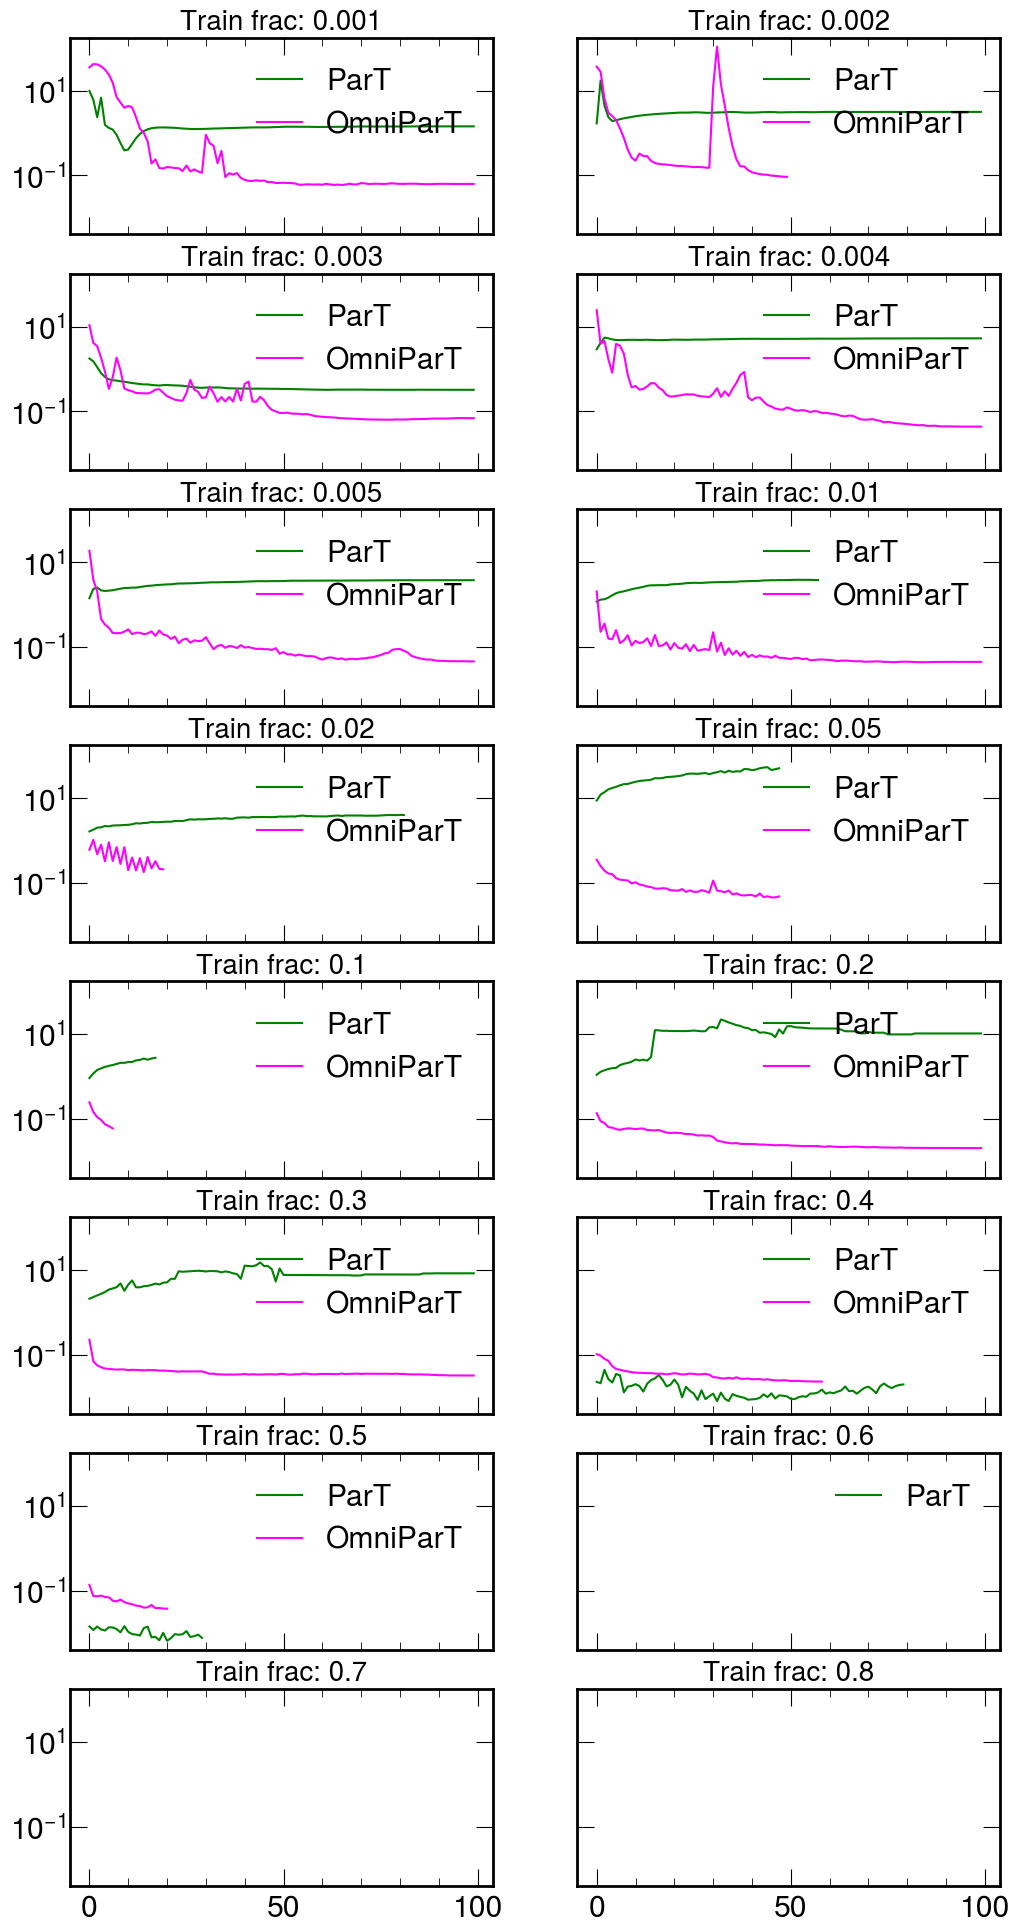

In [16]:
plot_losses(val_losses, "binary_classification")

# Current concerns

- The total number of trainable parameters for ParT is ~945k, while for OmniParT it is ~14.8M
- Binary classification for ParT seems to be not correct for an unknown reason
- 